In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import STM32FProgrammer

In [8]:
firmware_dir = '/home/wwa/data/cw/chipwhisperer/hardware/victims/firmware/simple_pass_timeinvar/'
hex_file = os.path.join(firmware_dir, r'main-CW308_STM32F0.hex')

In [9]:
#from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
#Resetter = ResetCW1173(pin='pdic', delay_ms=1)

In [10]:
# Notebook settings
%matplotlib notebook

In [5]:
scope = cw.scope()
target = cw.target(scope)

In [6]:
scope.gain.gain = 45
scope.adc.samples = 450
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

In [11]:
programmer = STM32FProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.open()
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

Detected known STMF32: STM32F071xx/STM32F072xx
Extended erase (0x44), this can take ten seconds or more
Attempting to programming 4551 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4551 bytes


In [12]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def reset(scope):
    scope.io.nrst='low'
    time.sleep(0.010)
    scope.io.nrst='high'
    time.sleep(0.025)
def runone(x,y,r=5):
    while r != 0:
        target.reinit()
        scope.arm()
        target.getConnection().hardware_write(x)
        target.getConnection().hardware_write(y)
        timeout = 50
        while target.isDone() is False and timeout > 0:
            timeout -= 1
            time.sleep(0.01)
        out = ""
        out = target.getConnection().hardware_read(1000)
        rst = scope.capture()
        if(not rst):
            return (scope.getLastTrace(),out)
        reset(scope)
        r -= 1
    return ()
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def glitch_setup(eoff,rep,off,wid):
    scope.io.hs2             = "glitch"
    scope.glitch.clk_src     = 'clkgen'
    scope.glitch.trigger_src = 'ext_single'
    scope.glitch.arm_timing  = 'after_scope'
    scope.glitch.output      = 'clock_xor'
    scope.glitch.ext_offset  = eoff
    scope.glitch.repeat      = rep
    scope.glitch.offset      = off
    scope.glitch.offset_fine = 0
    scope.glitch.width       = wid
    scope.glitch.width_fine  = 0

In [22]:
glitch_setup(1,1,1,1)
(trc,out) = runone(b'baaaaaaa',b'aaaaaaaa')
plot((trc,))
print(out)

<IPython.core.display.Javascript object>

[70, 97, 105, 108]


<IPython.core.display.Javascript object>


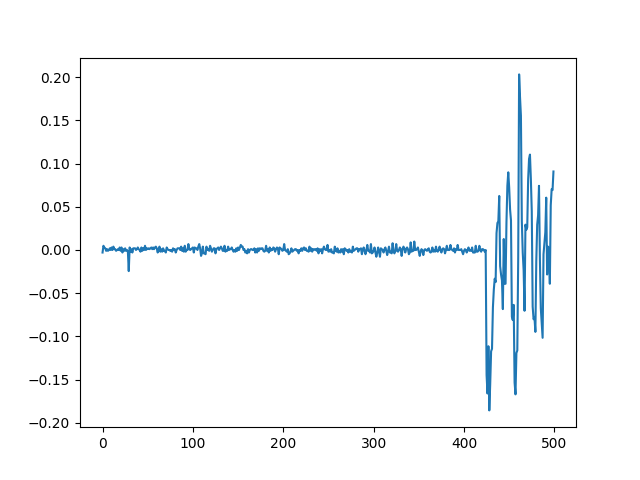

[70, 97, 105, 108]


In [26]:
glitch_setup(100,1,5,5)
(x,out) = runone(b'baaaaaaa',b'aaaaaaaa')
plot((x-trc,))
print(out)

In [29]:
idx = 0
for io in range(10):
    for iw in range(10):
        for ie in range(50):
            e = ie+90
            r = 1
            o = 4+io/10
            w = 2.6+iw/10
            glitch_setup(e,r,o,w)
            try:
                # retry 5 times before reporting failure
                (trc,out) = runone(b'baaaaaaa',b'aaaaaaaa',5)
            except ValueError as ioex:
                out = "[capture failed]"
                try:
                    # reset and try with "safe" params, make sure that works
                    glitch_setup(1,1,1,1)
                    runone('','',3)
                except ValueError as ioex2:
                    # "safe" params failed too, needs power cycle / reflash
                    raise Exception('Fatal, reset failed, cycle power')
            idx += 1
            print("i=",idx,"e=",e,"r=",r,"o=",o,"w=",w,":",out)

i= 1 e= 90 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 2 e= 91 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 3 e= 92 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 4 e= 93 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 5 e= 94 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 6 e= 95 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 7 e= 96 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 8 e= 97 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 9 e= 98 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 10 e= 99 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 11 e= 100 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 12 e= 101 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 13 e= 102 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 14 e= 103 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 15 e= 104 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 16 e= 105 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 17 e= 106 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 18 e= 107 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 19 e= 108 r= 1 o= 4.0 w= 2.6 : [70, 97, 105, 108]
i= 20 e= 109

i= 144 e= 133 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 145 e= 134 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 146 e= 135 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 147 e= 136 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 148 e= 137 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 149 e= 138 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 150 e= 139 r= 1 o= 4.0 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 151 e= 90 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 152 e= 91 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 153 e= 92 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 154 e= 93 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 155 e= 94 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 156 e= 95 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 157 e= 96 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 158 e= 97 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 159 e= 98 r= 1 o= 4.0 w= 2.9 : [70, 97, 105, 108]
i= 160 e= 99 r= 1 o= 4.0 w= 2.9 : [70, 9

i= 207 e= 96 r= 1 o= 4.0 w= 3.0 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 208 e= 97 r= 1 o= 4.0 w= 3.0 : []


i= 209 e= 98 r= 1 o= 4.0 w= 3.0 : [0, 0, 1, 1, 70, 97, 105, 108]
i= 210 e= 99 r= 1 o= 4.0 w= 3.0 : []


i= 211 e= 100 r= 1 o= 4.0 w= 3.0 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 212 e= 101 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 213 e= 102 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]


i= 214 e= 103 r= 1 o= 4.0 w= 3.0 : [1, 1]


i= 215 e= 104 r= 1 o= 4.0 w= 3.0 : [203, 0, 0, 0, 70, 97, 105, 108]
i= 216 e= 105 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 217 e= 106 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 218 e= 107 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 219 e= 108 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 220 e= 109 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 221 e= 110 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 222 e= 111 r= 1 o= 4.0 w= 3.0 : []


i= 223 e= 112 r= 1 o= 4.0 w= 3.0 : [235, 5, 0, 1, 70, 97, 105, 108]
i= 224 e= 113 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 225 e= 114 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 226 e= 115 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 227 e= 116 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 228 e= 117 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 229 e= 118 r= 1 o= 4.0 w= 3.0 : []


i= 230 e= 119 r= 1 o= 4.0 w= 3.0 : [1, 1, 0, 70, 97, 105, 108]
i= 231 e= 120 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 232 e= 121 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 233 e= 122 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 234 e= 123 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 235 e= 124 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 236 e= 125 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 237 e= 126 r= 1 o= 4.0 w= 3.0 : []


i= 238 e= 127 r= 1 o= 4.0 w= 3.0 : [8, 1, 1, 70, 97, 105, 108]
i= 239 e= 128 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 240 e= 129 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 241 e= 130 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 242 e= 131 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 243 e= 132 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 244 e= 133 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 245 e= 134 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 246 e= 135 r= 1 o= 4.0 w= 3.0 : [70, 97, 105, 108]
i= 247 e= 136 r= 1 o= 4.0 w= 3.0 : []


i= 248 e= 137 r= 1 o= 4.0 w= 3.0 : [0, 5, 0, 70, 97, 105, 108]
i= 249 e= 138 r= 1 o= 4.0 w= 3.0 : []


i= 250 e= 139 r= 1 o= 4.0 w= 3.0 : [0, 0]
i= 251 e= 90 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 252 e= 91 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 253 e= 92 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 254 e= 93 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 255 e= 94 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 256 e= 95 r= 1 o= 4.0 w= 3.1 : []


i= 257 e= 96 r= 1 o= 4.0 w= 3.1 : [0, 0, 0, 70, 97, 105, 108]
i= 258 e= 97 r= 1 o= 4.0 w= 3.1 : []


i= 259 e= 98 r= 1 o= 4.0 w= 3.1 : [0, 1, 0, 70, 97, 105, 108]
i= 260 e= 99 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 261 e= 100 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 262 e= 101 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 263 e= 102 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]


i= 264 e= 103 r= 1 o= 4.0 w= 3.1 : [8, 1, 0, 70, 97, 105, 108]
i= 265 e= 104 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 266 e= 105 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 267 e= 106 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 268 e= 107 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 269 e= 108 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 270 e= 109 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 271 e= 110 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 272 e= 111 r= 1 o= 4.0 w= 3.1 : []


i= 273 e= 112 r= 1 o= 4.0 w= 3.1 : [0, 0, 0, 70, 97, 105, 108]
i= 274 e= 113 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 275 e= 114 r= 1 o= 4.0 w= 3.1 : []


i= 276 e= 115 r= 1 o= 4.0 w= 3.1 : [0, 0, 70, 97, 105, 108]
i= 277 e= 116 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 278 e= 117 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 279 e= 118 r= 1 o= 4.0 w= 3.1 : []


i= 280 e= 119 r= 1 o= 4.0 w= 3.1 : [0, 0, 70, 97, 105, 108]
i= 281 e= 120 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 282 e= 121 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 283 e= 122 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 284 e= 123 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 285 e= 124 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 286 e= 125 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 287 e= 126 r= 1 o= 4.0 w= 3.1 : []


i= 288 e= 127 r= 1 o= 4.0 w= 3.1 : [0, 0, 70, 97, 105, 108]
i= 289 e= 128 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 290 e= 129 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 291 e= 130 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 292 e= 131 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 293 e= 132 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 294 e= 133 r= 1 o= 4.0 w= 3.1 : [80, 97, 115, 115]
i= 295 e= 134 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 296 e= 135 r= 1 o= 4.0 w= 3.1 : [70, 97, 105, 108]
i= 297 e= 136 r= 1 o= 4.0 w= 3.1 : []


i= 298 e= 137 r= 1 o= 4.0 w= 3.1 : [8, 0, 70, 97, 105, 108]
i= 299 e= 138 r= 1 o= 4.0 w= 3.1 : []


i= 300 e= 139 r= 1 o= 4.0 w= 3.1 : [0, 5, 0]
i= 301 e= 90 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 302 e= 91 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 303 e= 92 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 304 e= 93 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 305 e= 94 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 306 e= 95 r= 1 o= 4.0 w= 3.2 : []


i= 307 e= 96 r= 1 o= 4.0 w= 3.2 : [1, 0, 1, 0, 70, 97, 105, 108]
i= 308 e= 97 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 309 e= 98 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 310 e= 99 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 311 e= 100 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 312 e= 101 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 313 e= 102 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 314 e= 103 r= 1 o= 4.0 w= 3.2 : []


i= 315 e= 104 r= 1 o= 4.0 w= 3.2 : [1, 0, 0, 0, 70, 97, 105, 108]
i= 316 e= 105 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 317 e= 106 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 318 e= 107 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 319 e= 108 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 320 e= 109 r= 1 o= 4.0 w= 3.2 : []


i= 321 e= 110 r= 1 o= 4.0 w= 3.2 : [32, 0, 0, 70, 97, 105, 108]
i= 322 e= 111 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 323 e= 112 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 324 e= 113 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 325 e= 114 r= 1 o= 4.0 w= 3.2 : []


i= 326 e= 115 r= 1 o= 4.0 w= 3.2 : [0, 70, 97, 105, 108]
i= 327 e= 116 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 328 e= 117 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 329 e= 118 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 330 e= 119 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 331 e= 120 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 332 e= 121 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 333 e= 122 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 334 e= 123 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 335 e= 124 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 336 e= 125 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 337 e= 126 r= 1 o= 4.0 w= 3.2 : []


i= 338 e= 127 r= 1 o= 4.0 w= 3.2 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 339 e= 128 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 340 e= 129 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 341 e= 130 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 342 e= 131 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 343 e= 132 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 344 e= 133 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 345 e= 134 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 346 e= 135 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 347 e= 136 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 348 e= 137 r= 1 o= 4.0 w= 3.2 : [70, 97, 105, 108]
i= 349 e= 138 r= 1 o= 4.0 w= 3.2 : []


i= 350 e= 139 r= 1 o= 4.0 w= 3.2 : [235, 8, 1]
i= 351 e= 90 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 352 e= 91 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 353 e= 92 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 354 e= 93 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 355 e= 94 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 356 e= 95 r= 1 o= 4.0 w= 3.3 : []


i= 357 e= 96 r= 1 o= 4.0 w= 3.3 : [40, 32, 32, 70, 97, 105, 108]
i= 358 e= 97 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 359 e= 98 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 360 e= 99 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 361 e= 100 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 362 e= 101 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 363 e= 102 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]


i= 364 e= 103 r= 1 o= 4.0 w= 3.3 : [153, 0, 0, 70, 97, 105, 108]
i= 365 e= 104 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 366 e= 105 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]


i= 367 e= 106 r= 1 o= 4.0 w= 3.3 : [235, 0, 1, 0, 70, 97, 105, 108]
i= 368 e= 107 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 369 e= 108 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 370 e= 109 r= 1 o= 4.0 w= 3.3 : []


i= 371 e= 110 r= 1 o= 4.0 w= 3.3 : [137, 9, 1, 1, 70, 97, 105, 108]
i= 372 e= 111 r= 1 o= 4.0 w= 3.3 : []


i= 373 e= 112 r= 1 o= 4.0 w= 3.3 : [201, 8, 0, 0, 0, 70, 97, 105, 108]
i= 374 e= 113 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 375 e= 114 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 376 e= 115 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 377 e= 116 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 378 e= 117 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 379 e= 118 r= 1 o= 4.0 w= 3.3 : []


i= 380 e= 119 r= 1 o= 4.0 w= 3.3 : [235, 0, 0, 0, 70, 97, 105, 108]
i= 381 e= 120 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 382 e= 121 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 383 e= 122 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 384 e= 123 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 385 e= 124 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 386 e= 125 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 387 e= 126 r= 1 o= 4.0 w= 3.3 : []


i= 388 e= 127 r= 1 o= 4.0 w= 3.3 : [0, 0, 0, 70, 97, 105, 108]
i= 389 e= 128 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 390 e= 129 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 391 e= 130 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 392 e= 131 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 393 e= 132 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 394 e= 133 r= 1 o= 4.0 w= 3.3 : [80, 97, 115, 115]
i= 395 e= 134 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 396 e= 135 r= 1 o= 4.0 w= 3.3 : [70, 97, 105, 108]
i= 397 e= 136 r= 1 o= 4.0 w= 3.3 : []


i= 398 e= 137 r= 1 o= 4.0 w= 3.3 : [0, 0, 0, 70, 97, 105, 108]
i= 399 e= 138 r= 1 o= 4.0 w= 3.3 : []


i= 400 e= 139 r= 1 o= 4.0 w= 3.3 : [8, 0, 0, 0]
i= 401 e= 90 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 402 e= 91 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 403 e= 92 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 404 e= 93 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 405 e= 94 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 406 e= 95 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 407 e= 96 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 408 e= 97 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 409 e= 98 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 410 e= 99 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 411 e= 100 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 412 e= 101 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 413 e= 102 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 108]
i= 414 e= 103 r= 1 o= 4.0 w= 3.4000000000000004 : [70, 97, 105, 1

i= 451 e= 90 r= 1 o= 4.0 w= 3.5 : [203, 128, 0, 1, 0, 70, 97, 105, 108]
i= 452 e= 91 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 453 e= 92 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 454 e= 93 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 455 e= 94 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 456 e= 95 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 457 e= 96 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 458 e= 97 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 459 e= 98 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 460 e= 99 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 461 e= 100 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 462 e= 101 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 463 e= 102 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 464 e= 103 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 465 e= 104 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 466 e= 105 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 467 e= 106 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 468 e= 107 r= 1 o= 4.0 w= 3.5 : [70, 97, 105, 108]
i= 469 e= 108 r= 1 

i= 501 e= 90 r= 1 o= 4.1 w= 2.6 : [1, 0, 0, 0, 70, 97, 105, 108]
i= 502 e= 91 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 503 e= 92 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 504 e= 93 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 505 e= 94 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 506 e= 95 r= 1 o= 4.1 w= 2.6 : []


i= 507 e= 96 r= 1 o= 4.1 w= 2.6 : [0, 0, 0, 70, 97, 105, 108]
i= 508 e= 97 r= 1 o= 4.1 w= 2.6 : []


i= 509 e= 98 r= 1 o= 4.1 w= 2.6 : [0, 0, 0, 70, 97, 105, 108]
i= 510 e= 99 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 511 e= 100 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 512 e= 101 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 513 e= 102 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]


i= 514 e= 103 r= 1 o= 4.1 w= 2.6 : [0, 0, 0, 70, 97, 105, 108]
i= 515 e= 104 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 516 e= 105 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]


i= 517 e= 106 r= 1 o= 4.1 w= 2.6 : [1, 0, 0, 70, 97, 105, 108]
i= 518 e= 107 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 519 e= 108 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 520 e= 109 r= 1 o= 4.1 w= 2.6 : []


i= 521 e= 110 r= 1 o= 4.1 w= 2.6 : [0, 0, 0, 70, 97, 105, 108]
i= 522 e= 111 r= 1 o= 4.1 w= 2.6 : []


i= 523 e= 112 r= 1 o= 4.1 w= 2.6 : [1, 0, 70, 97, 105, 108]
i= 524 e= 113 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 525 e= 114 r= 1 o= 4.1 w= 2.6 : []


i= 526 e= 115 r= 1 o= 4.1 w= 2.6 : [239, 32, 1, 70, 97, 105, 108]
i= 527 e= 116 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 528 e= 117 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 529 e= 118 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]


i= 530 e= 119 r= 1 o= 4.1 w= 2.6 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 531 e= 120 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]


i= 532 e= 121 r= 1 o= 4.1 w= 2.6 : [235, 1, 0, 70, 97, 105, 108]
i= 533 e= 122 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 534 e= 123 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 535 e= 124 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 536 e= 125 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 537 e= 126 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 538 e= 127 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 539 e= 128 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 540 e= 129 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 541 e= 130 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 542 e= 131 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 543 e= 132 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 544 e= 133 r= 1 o= 4.1 w= 2.6 : []


i= 545 e= 134 r= 1 o= 4.1 w= 2.6 : [0, 1, 0, 0, 70, 97, 105, 108]
i= 546 e= 135 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 547 e= 136 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 548 e= 137 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 549 e= 138 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 550 e= 139 r= 1 o= 4.1 w= 2.6 : [70, 97, 105, 108]
i= 551 e= 90 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 552 e= 91 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 553 e= 92 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 554 e= 93 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 555 e= 94 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 556 e= 95 r= 1 o= 4.1 w= 2.7 : []


i= 557 e= 96 r= 1 o= 4.1 w= 2.7 : [32, 4, 0, 0, 0, 70, 97, 105, 108]
i= 558 e= 97 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 559 e= 98 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 560 e= 99 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 561 e= 100 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 562 e= 101 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 563 e= 102 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]


i= 564 e= 103 r= 1 o= 4.1 w= 2.7 : [239, 0, 1, 0, 0]


i= 565 e= 104 r= 1 o= 4.1 w= 2.7 : [0, 1, 0, 70, 97, 105, 108]
i= 566 e= 105 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]


i= 567 e= 106 r= 1 o= 4.1 w= 2.7 : [235, 0, 0, 70, 97, 105, 108]
i= 568 e= 107 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 569 e= 108 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 570 e= 109 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 571 e= 110 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 572 e= 111 r= 1 o= 4.1 w= 2.7 : []


i= 573 e= 112 r= 1 o= 4.1 w= 2.7 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 574 e= 113 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 575 e= 114 r= 1 o= 4.1 w= 2.7 : []


i= 576 e= 115 r= 1 o= 4.1 w= 2.7 : [0, 0, 0, 70, 97, 105, 108]
i= 577 e= 116 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 578 e= 117 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 579 e= 118 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]


i= 580 e= 119 r= 1 o= 4.1 w= 2.7 : [0, 1, 0, 70, 97, 105, 108]
i= 581 e= 120 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 582 e= 121 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 583 e= 122 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 584 e= 123 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 585 e= 124 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 586 e= 125 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 587 e= 126 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 588 e= 127 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 589 e= 128 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 590 e= 129 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 591 e= 130 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 592 e= 131 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 593 e= 132 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 594 e= 133 r= 1 o= 4.1 w= 2.7 : []


i= 595 e= 134 r= 1 o= 4.1 w= 2.7 : [223, 0, 0, 1, 0, 70, 97, 105, 108]
i= 596 e= 135 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 597 e= 136 r= 1 o= 4.1 w= 2.7 : []


i= 598 e= 137 r= 1 o= 4.1 w= 2.7 : [8, 0, 0, 70, 97, 105, 108]
i= 599 e= 138 r= 1 o= 4.1 w= 2.7 : [70, 97, 105, 108]
i= 600 e= 139 r= 1 o= 4.1 w= 2.7 : []
i= 601 e= 90 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 602 e= 91 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 603 e= 92 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 604 e= 93 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 605 e= 94 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 606 e= 95 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 607 e= 96 r= 1 o= 4.1 w= 2.8000000000000003 : [8, 0, 70, 97, 105, 108]
i= 608 e= 97 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 609 e= 98 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 610 e= 99 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 611 e= 100 r= 1 o= 4.1 w= 2.8000000000000003 : [0, 1, 0, 70, 97, 105, 108]
i= 612 e= 101 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 613 e= 102 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 614 e= 103 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 615 e= 104 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 616 e= 105 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]


i= 617 e= 106 r= 1 o= 4.1 w= 2.8000000000000003 : [0, 0, 1, 0, 70, 97, 105, 108]
i= 618 e= 107 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 619 e= 108 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 620 e= 109 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 621 e= 110 r= 1 o= 4.1 w= 2.8000000000000003 : [0, 0, 70, 97, 105, 108]
i= 622 e= 111 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 623 e= 112 r= 1 o= 4.1 w= 2.8000000000000003 : [0, 0, 0, 70, 97, 105, 108]
i= 624 e= 113 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 625 e= 114 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 626 e= 115 r= 1 o= 4.1 w= 2.8000000000000003 : [201, 32, 1, 0, 0, 70, 97, 105, 108]
i= 627 e= 116 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 628 e= 117 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 629 e= 118 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]


i= 630 e= 119 r= 1 o= 4.1 w= 2.8000000000000003 : [1, 0, 70, 97, 105, 108]
i= 631 e= 120 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 632 e= 121 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 633 e= 122 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 634 e= 123 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 635 e= 124 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 636 e= 125 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 637 e= 126 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 638 e= 127 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 639 e= 128 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 640 e= 129 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 641 e= 130 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 642 e= 131 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 643 e= 132 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 644 e= 133 r= 1 o= 4.1 w=

i= 645 e= 134 r= 1 o= 4.1 w= 2.8000000000000003 : [0, 0, 0, 70, 97, 105, 108]
i= 646 e= 135 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 647 e= 136 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 648 e= 137 r= 1 o= 4.1 w= 2.8000000000000003 : [70, 97, 105, 108]
i= 649 e= 138 r= 1 o= 4.1 w= 2.8000000000000003 : []


i= 650 e= 139 r= 1 o= 4.1 w= 2.8000000000000003 : [235, 8, 0, 0]
i= 651 e= 90 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 652 e= 91 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 653 e= 92 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 654 e= 93 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 655 e= 94 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 656 e= 95 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 657 e= 96 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 658 e= 97 r= 1 o= 4.1 w= 2.9 : []


i= 659 e= 98 r= 1 o= 4.1 w= 2.9 : [0, 0, 0, 70, 97, 105, 108]
i= 660 e= 99 r= 1 o= 4.1 w= 2.9 : []


i= 661 e= 100 r= 1 o= 4.1 w= 2.9 : [4, 0, 0, 0, 70, 97, 105, 108]
i= 662 e= 101 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 663 e= 102 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]


i= 664 e= 103 r= 1 o= 4.1 w= 2.9 : [0, 0, 0, 0]


i= 665 e= 104 r= 1 o= 4.1 w= 2.9 : [0, 0, 70, 97, 105, 108]
i= 666 e= 105 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]


i= 667 e= 106 r= 1 o= 4.1 w= 2.9 : [0, 0, 70, 97, 105, 108]
i= 668 e= 107 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 669 e= 108 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 670 e= 109 r= 1 o= 4.1 w= 2.9 : []


i= 671 e= 110 r= 1 o= 4.1 w= 2.9 : [0, 0, 70, 97, 105, 108]
i= 672 e= 111 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 673 e= 112 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 674 e= 113 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 675 e= 114 r= 1 o= 4.1 w= 2.9 : []


i= 676 e= 115 r= 1 o= 4.1 w= 2.9 : [0, 0, 0, 0, 70, 97, 105, 108]
i= 677 e= 116 r= 1 o= 4.1 w= 2.9 : []


i= 678 e= 117 r= 1 o= 4.1 w= 2.9 : [203, 0, 1, 0, 0, 70, 97, 105, 108]
i= 679 e= 118 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 680 e= 119 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 681 e= 120 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]


i= 682 e= 121 r= 1 o= 4.1 w= 2.9 : [32, 0, 0, 70, 97, 105, 108]
i= 683 e= 122 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 684 e= 123 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 685 e= 124 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 686 e= 125 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 687 e= 126 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 688 e= 127 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 689 e= 128 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 690 e= 129 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 691 e= 130 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 692 e= 131 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 693 e= 132 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 694 e= 133 r= 1 o= 4.1 w= 2.9 : []


i= 695 e= 134 r= 1 o= 4.1 w= 2.9 : [235, 0, 1, 0, 70, 97, 105, 108]
i= 696 e= 135 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 697 e= 136 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 698 e= 137 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 699 e= 138 r= 1 o= 4.1 w= 2.9 : [70, 97, 105, 108]
i= 700 e= 139 r= 1 o= 4.1 w= 2.9 : []
i= 701 e= 90 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 702 e= 91 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 703 e= 92 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 704 e= 93 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 705 e= 94 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 706 e= 95 r= 1 o= 4.1 w= 3.0 : []


i= 707 e= 96 r= 1 o= 4.1 w= 3.0 : [1, 1, 0, 70, 97, 105, 108]
i= 708 e= 97 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 709 e= 98 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 710 e= 99 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 711 e= 100 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 712 e= 101 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 713 e= 102 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]


i= 714 e= 103 r= 1 o= 4.1 w= 3.0 : [32, 0, 0, 70, 97, 105, 108]
i= 715 e= 104 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 716 e= 105 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 717 e= 106 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 718 e= 107 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 719 e= 108 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 720 e= 109 r= 1 o= 4.1 w= 3.0 : []


i= 721 e= 110 r= 1 o= 4.1 w= 3.0 : [0, 0, 70, 97, 105, 108]
i= 722 e= 111 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 723 e= 112 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 724 e= 113 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 725 e= 114 r= 1 o= 4.1 w= 3.0 : []


i= 726 e= 115 r= 1 o= 4.1 w= 3.0 : [8, 0, 70, 97, 105, 108]
i= 727 e= 116 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 728 e= 117 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 729 e= 118 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 730 e= 119 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 731 e= 120 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 732 e= 121 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 733 e= 122 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 734 e= 123 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 735 e= 124 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 736 e= 125 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 737 e= 126 r= 1 o= 4.1 w= 3.0 : []


i= 738 e= 127 r= 1 o= 4.1 w= 3.0 : [0, 0, 0, 70, 97, 105, 108]
i= 739 e= 128 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 740 e= 129 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 741 e= 130 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 742 e= 131 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 743 e= 132 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 744 e= 133 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 745 e= 134 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 746 e= 135 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 747 e= 136 r= 1 o= 4.1 w= 3.0 : []


i= 748 e= 137 r= 1 o= 4.1 w= 3.0 : [32, 0, 0, 0, 70, 97, 105, 108]
i= 749 e= 138 r= 1 o= 4.1 w= 3.0 : [70, 97, 105, 108]
i= 750 e= 139 r= 1 o= 4.1 w= 3.0 : []
i= 751 e= 90 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 752 e= 91 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 753 e= 92 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 754 e= 93 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 755 e= 94 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 756 e= 95 r= 1 o= 4.1 w= 3.1 : []


i= 757 e= 96 r= 1 o= 4.1 w= 3.1 : [153, 32, 1, 0, 70, 97, 105, 108]
i= 758 e= 97 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 759 e= 98 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 760 e= 99 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 761 e= 100 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 762 e= 101 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 763 e= 102 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]


i= 764 e= 103 r= 1 o= 4.1 w= 3.1 : [0, 0, 0]


i= 765 e= 104 r= 1 o= 4.1 w= 3.1 : [1, 0, 70, 97, 105, 108]
i= 766 e= 105 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 767 e= 106 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 768 e= 107 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 769 e= 108 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 770 e= 109 r= 1 o= 4.1 w= 3.1 : []


i= 771 e= 110 r= 1 o= 4.1 w= 3.1 : [235, 0, 0, 1, 1, 0, 70, 97, 105, 108]
i= 772 e= 111 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 773 e= 112 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 774 e= 113 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 775 e= 114 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 776 e= 115 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 777 e= 116 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 778 e= 117 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 779 e= 118 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 780 e= 119 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 781 e= 120 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 782 e= 121 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 783 e= 122 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 784 e= 123 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 785 e= 124 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 786 e= 125 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 787 e= 126 r= 1 o= 4.1 w= 3.1 : []


i= 788 e= 127 r= 1 o= 4.1 w= 3.1 : [0, 0, 0, 70, 97, 105, 108]
i= 789 e= 128 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 790 e= 129 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 791 e= 130 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 792 e= 131 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 793 e= 132 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 794 e= 133 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 795 e= 134 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 796 e= 135 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 797 e= 136 r= 1 o= 4.1 w= 3.1 : []


i= 798 e= 137 r= 1 o= 4.1 w= 3.1 : [203, 8, 1, 0, 70, 97, 105, 108]
i= 799 e= 138 r= 1 o= 4.1 w= 3.1 : [70, 97, 105, 108]
i= 800 e= 139 r= 1 o= 4.1 w= 3.1 : []
i= 801 e= 90 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 802 e= 91 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 803 e= 92 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 804 e= 93 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 805 e= 94 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 806 e= 95 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 807 e= 96 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 808 e= 97 r= 1 o= 4.1 w= 3.2 : []


i= 809 e= 98 r= 1 o= 4.1 w= 3.2 : [32, 1, 0, 70, 97, 105, 108]
i= 810 e= 99 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]
i= 811 e= 100 r= 1 o= 4.1 w= 3.2 : [70, 97, 105, 108]


KeyboardInterrupt: 

In [ ]:
idx = 0
for ie in range(3):
    for io in range(10):
        for iw in range(10):
            e = ie+5
            r = 1
            o = 4+io/5
            w = 2+iw/10
            glitch_setup(e,r,o,w)
            try:
                # retry 5 times before reporting failure
                (trc,out) = runone('','',5)
            except ValueError as ioex:
                out = "[capture failed]"
                try:
                    # reset and try with "safe" params, make sure that works
                    glitch_setup(1,1,1,1)
                    runone('','',3)
                except ValueError as ioex2:
                    # "safe" params failed too, needs power cycle / reflash
                    raise Exception('Fatal, reset failed, cycle power')
            idx += 1
            print("i=",idx,"e=",e,"r=",r,"o=",o,"w=",w,":",out)

In [ ]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()